In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ravdess-emotional-speech-audio:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F107620%2F256618%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240708%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240708T043059Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5bfa426459b0745381e33767ce9b82c6614dca049c755fcb0c06e0202925899d4411f4d8cb9e7a52e1bfceb98c09c9012c0372ee93ff7cf7cb25953ac3ca8c8d54751fc0f4f027d0a4da2454a4b4faa2eae18b60a943495dbb2c1ce92d0f3f9e692bc5bda47541fd0ee851c5b21e33ca5c02e63c2b44830625bfbf2e1c5d09784fdb61fd5fe1c6cc1629c5d0e8a79c734dd5ef562c7c4d6e600950bdd710338b91041de2db44d3856566f530732d8085675933565589b6dd6f17f30f776015954b2cfabaaad0c371daf60e860da197dc5384b1784445613043ced5117193c76175d24608ce4300c6e4f7cc01ec5ad992744987ffa1a44df826ed587edf454e54'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 450102890 bytes downloaded
Downloaded and uncompressed: ravdess-emotional-speech-audio
Data source import complete.


# INTRODUCTION

**PROBLEM STATEMENT**

The purpose is to recognize the emotion and affective state of the speaker from his/her speech signal.

**DATA SOURCE USED**

We have used the RAVDESS dataset in this project.It is one of the more common dataset used for this excercise by others. It's well liked because of its quality of speakers, recording and it has 24 actors of different genders.
Here's the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Here's an example of an audio filename. 02-01-06-01-02-01-12.mp4

# EXPLORATORY DATA ANALYSIS

The key features of the audio data are namely, MFCC (Mel Frequency Cepstral Coefficients) and Mel Spectrogram

* MFCC (Mel Frequency Cepstral Coefficients)-
MFCC is important feature extraction when using speech data,Mel scale is a scale that relates the perceived frequency of a tone to the real measured frequency. It scales the frequency so that you can fit greater carefully what the human ear can hear



* Mel Spectrogram-
A Fast Fourier Transform is computed on overlapping windowed segments of the signal, and what is the spectrogram , Spectrogram is visual way of representation of signal strength and also use for display the frequency sound waves.



For the EDA we have used MFCC and Mel Spectogram

In [ ]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys
!pip install resampy
import resampy
# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD


import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 30.7 MB/s eta 0:00:00


In [ ]:
# path to the directory
RAVD = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"

In [ ]:
dirl_list = os.listdir(RAVD)
dirl_list.sort()

emotion = []
gender = []
path = []
for i in dirl_list:
    fname = os.listdir(RAVD + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAVD + i + '/' + f)


RAVD_df = pd.DataFrame(emotion)
RAVD_df = RAVD_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAVD_df = pd.concat([pd.DataFrame(gender),RAVD_df],axis=1)
RAVD_df.columns = ['gender','emotion']
RAVD_df['labels'] =RAVD_df.gender + '_' + RAVD_df.emotion
RAVD_df['source'] = 'RAVDESS'
RAVD_df = pd.concat([RAVD_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAVD_df = RAVD_df.drop(['gender', 'emotion'], axis=1)
RAVD_df.labels.value_counts()

labels
male_neutral       144
female_neutral     144
male_sad            96
male_angry          96
male_disgust        96
male_fear           96
male_happy          96
male_surprise       96
female_happy        96
female_fear         96
female_surprise     96
female_sad          96
female_disgust      96
female_angry        96
Name: count, dtype: int64

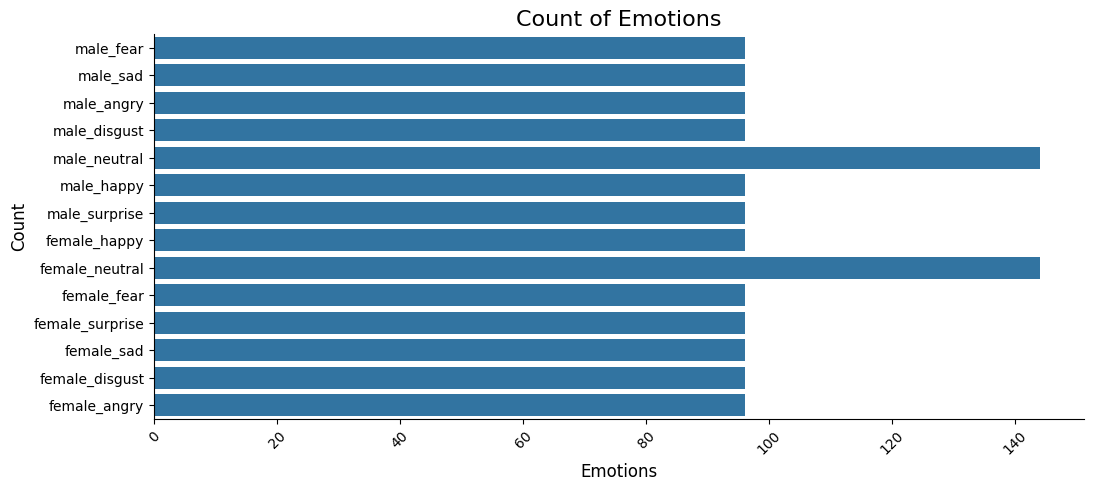

In [ ]:
plt.figure(figsize=(12, 5))
plt.title('Count of Emotions', size=16)
sns.countplot(RAVD_df.labels)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.xticks(rotation=45)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
# Female Happy
fRA1= RAVD + 'Actor_08/03-01-03-02-02-01-08.wav'
data, sr = librosa.load(fRA1)
ipd.Audio(fRA1)


In [ ]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000)
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Female Happy')
plt.colorbar(format='%+2.0f dB')

NameError: name 'sr' is not defined

<Figure size 1000x500 with 0 Axes>

In [ ]:
#Female Fear
fRA2=RAVD +'Actor_08/03-01-06-01-01-01-08.wav'
data, sr = librosa.load(fRA2)
ipd.Audio(fRA2)

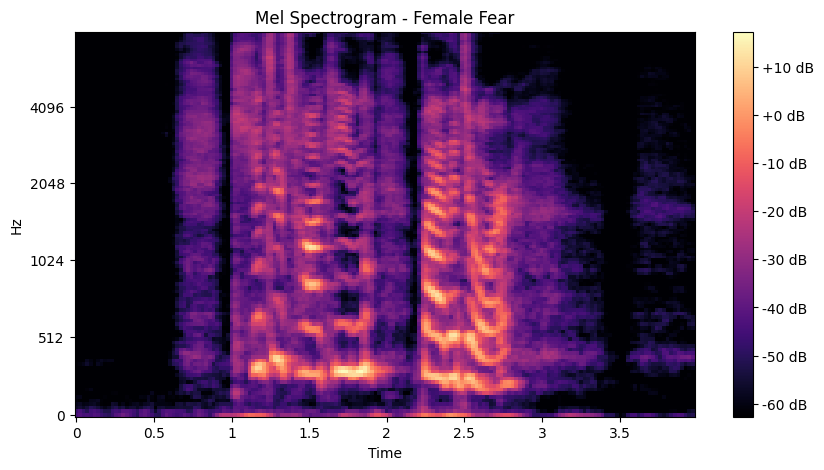

In [ ]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000)
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Female Fear')
plt.colorbar(format='%+2.0f dB');

Next, we compare the waveplots of happy and fearful tracks

In [ ]:
# Female Disgust
fRA1 =RAVD +'Actor_20/03-01-08-02-02-02-20.wav'
data, sr = librosa.load(fRA1)
ipd.Audio(fRA1)

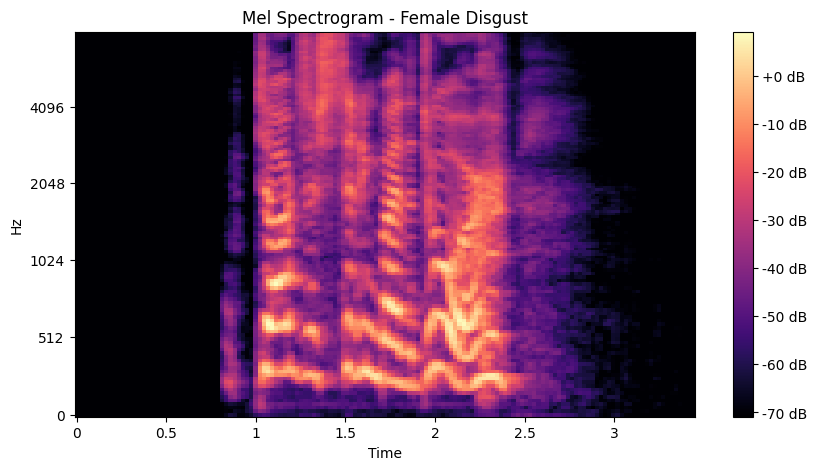

In [ ]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000)
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Female Disgust')
plt.colorbar(format='%+2.0f dB');

In [ ]:
# Male Fearfull
fRA1 = RAVD + 'Actor_19/03-01-04-01-02-01-19.wav'
data, sr = librosa.load(fRA1)
ipd.Audio(fRA1)

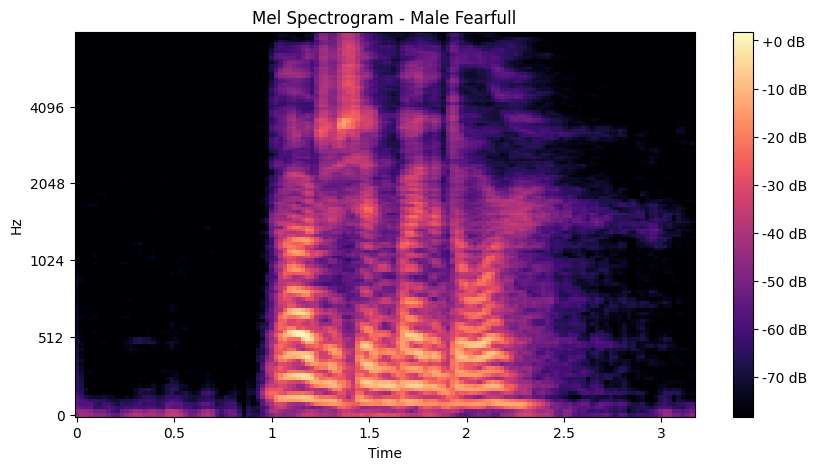

In [ ]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000)
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Male Fearfull')
plt.colorbar(format='%+2.0f dB');

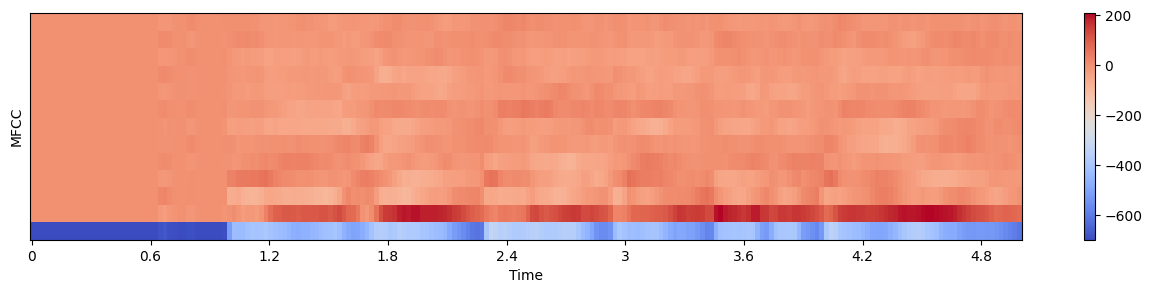

In [ ]:
# Gender - Female; Emotion - Angry
path = "../input/ravdess-emotional-speech-audio/Actor_18/03-01-05-01-01-01-18.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)


# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

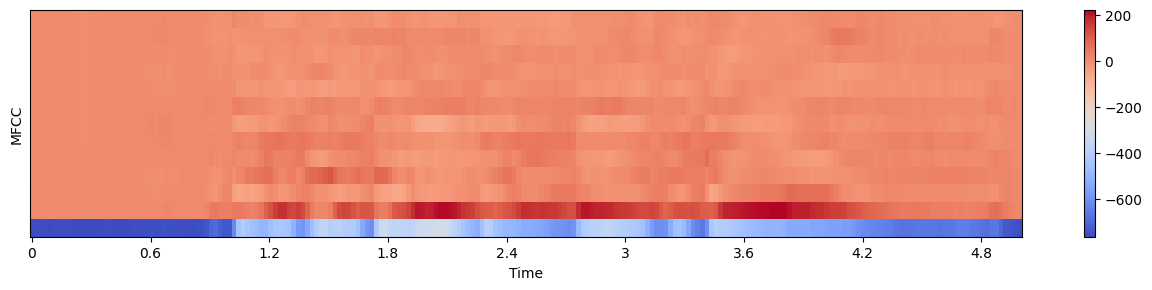

In [ ]:
# Gender - Male; Emotion - Angry
path = "../input/ravdess-emotional-speech-audio/Actor_17/03-01-05-01-01-02-17.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)


# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

216
216


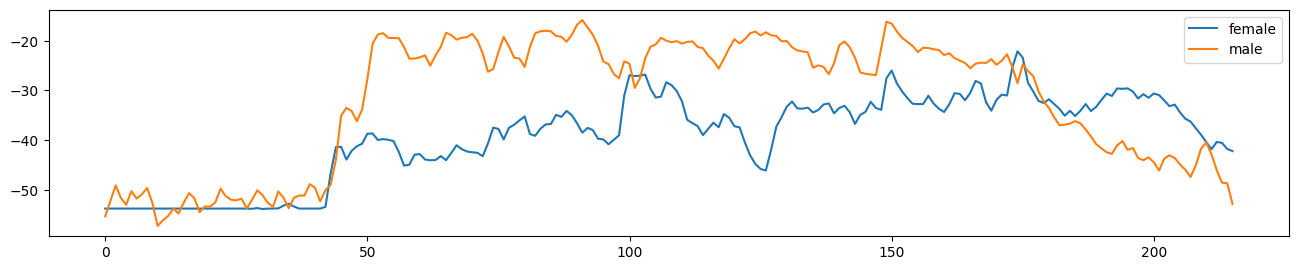

In [ ]:
# Gender - Female; Emotion - angry
path = "../input/ravdess-emotional-speech-audio/Actor_18/03-01-05-01-01-01-18.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

# Gender - Male; Emotion - angry
path = "../input/ravdess-emotional-speech-audio/Actor_17/03-01-05-01-01-02-17.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

# Plot the two audio waves together
plt.figure(figsize=(16,10))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()

216
216


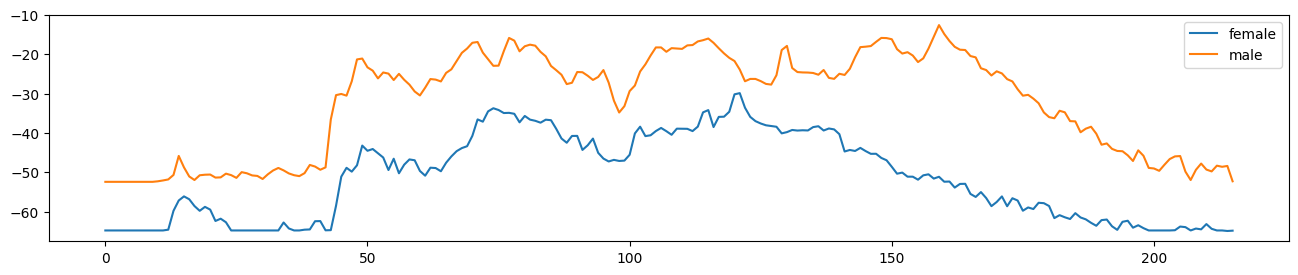

In [ ]:
# Gender - Female; Emotion - Surprised
path = "../input/ravdess-emotional-speech-audio/Actor_20/03-01-08-02-01-02-20.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

# Gender - Male; Emotion - Surprised
path = "../input/ravdess-emotional-speech-audio/Actor_21/03-01-08-02-01-01-21.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

# Plot the two audio waves together
plt.figure(figsize=(16,10))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()

**Again we combine the emotion of suprised male female then again male has higher pitch**

# DATA AUGMENTATION

* Data augmentation is the process by which we create new polymerized data samples by adding small disturbance on our initial training set.
* To generate polymerized data for audio, we can apply noise injection, shifting time, changing pitch and speed.
* The objective is to make our model invariant to those disturbance and enhace its ability to generalize.
In order to this to work adding the disturbance must conserve the same label as the original training sample.

In [ ]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data
# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data,rate=rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

In [ ]:
# Trying different functions above
path = np.array(RAVD_df['path'])[471]
data, sample_rate = librosa.load(path)

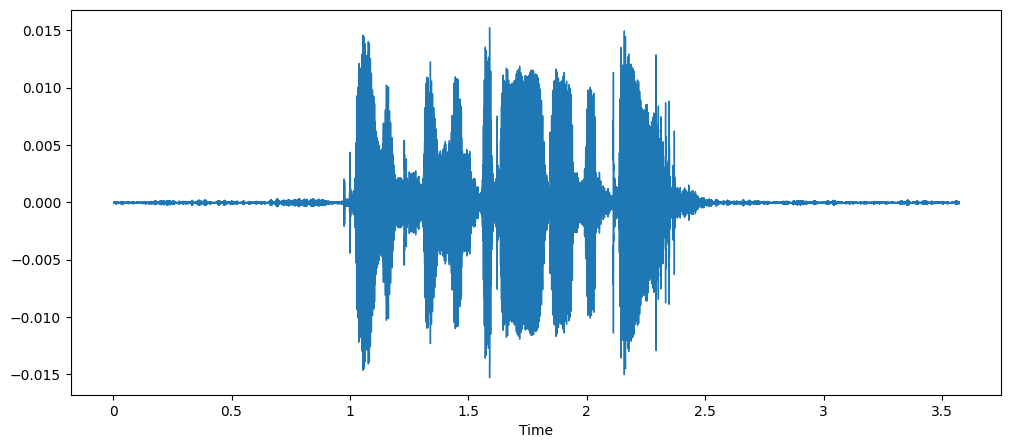

In [ ]:
# NORMAL AUDIO


import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

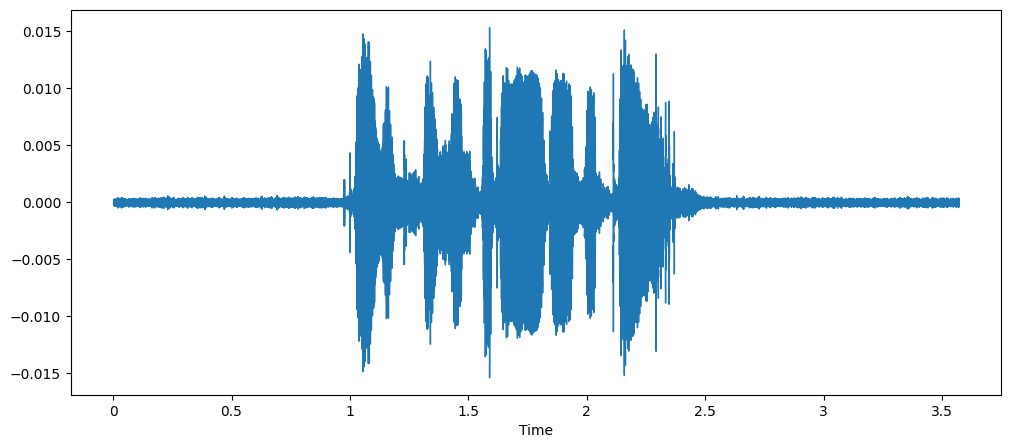

In [ ]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sample_rate)
plt.show()
Audio(x, rate=sample_rate)

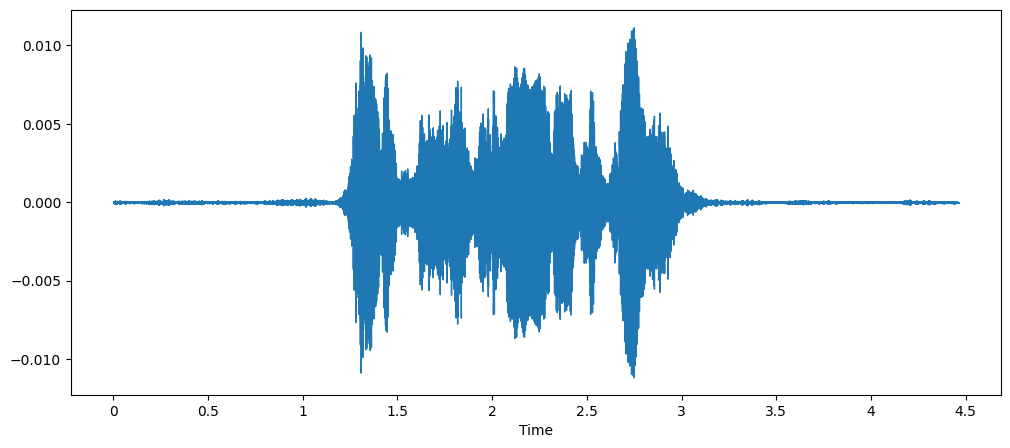

In [ ]:
# STRETCHED AUDIO
x = stretch(data)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

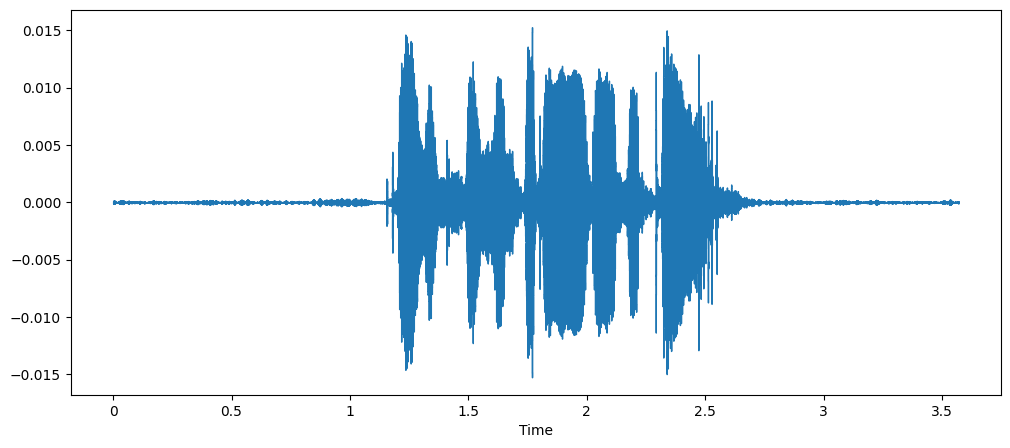

In [ ]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

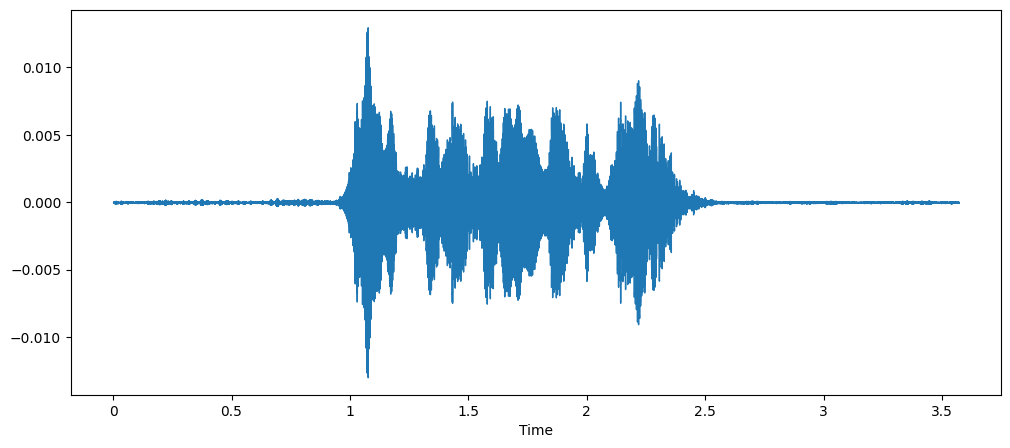

In [ ]:
# AUDIO WITH PITCH
x = pitch(data,sample_rate)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

**After listening to all audio we determine to use noise, shift and stretch**

# FEATURE EXTRACTION

In [ ]:

def feat_ext(data):
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    return mfcc

def get_feat(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    # normal data
    res1 = feat_ext(data)
    result = np.array(res1)
    #data with noise
    noise_data = noise(data)
    res2 = feat_ext(noise_data)
    result = np.vstack((result, res2))
    #data with stretch and pitch
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = feat_ext(data_stretch_pitch)
    result = np.vstack((result, res3))
    return result

In [ ]:
RAVD_df.head()

labels   source                                               path
0     male_fear  RAVDESS  /kaggle/input/ravdess-emotional-speech-audio/a...
1      male_sad  RAVDESS  /kaggle/input/ravdess-emotional-speech-audio/a...
2      male_sad  RAVDESS  /kaggle/input/ravdess-emotional-speech-audio/a...
3    male_angry  RAVDESS  /kaggle/input/ravdess-emotional-speech-audio/a...
4  male_disgust  RAVDESS  /kaggle/input/ravdess-emotional-speech-audio/a...

In [ ]:
X, Y = [], []
for path, emotion in zip(RAVD_df['path'], RAVD_df['labels']):
    feature = get_feat(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [ ]:
Emotions = pd.DataFrame(X)
Emotions['labels'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

0          1         2          3         4         5          6  \
0 -556.241516  73.592583  2.995840  20.293449  8.851416  1.278939  -4.569687   
1 -458.779956  49.155700  6.374219  14.827033  7.481838  0.208675  -4.627000   
2 -610.298645  69.670761  1.950849  18.653103  4.970779 -1.112439  -8.687943   
3 -509.330811  75.661858 -6.231736  19.756632  3.382503 -4.651091 -10.498844   
4 -350.523534  32.487925  8.963644  11.445712  2.628144 -3.665000  -6.859952   

           7          8         9  ...        11        12        13  \
0  -9.849459 -13.582756 -1.946103  ... -2.572281  0.884111 -5.505061   
1 -10.514545 -10.852247 -3.724139  ... -2.504678 -0.454042 -4.500099   
2 -14.340153 -13.111650 -1.025362  ... -1.100249 -1.713721 -7.842318   
3 -13.303314 -23.842730 -5.817672  ... -9.140257  0.616486 -9.573681   
4 -11.755893 -13.658689 -7.631959  ... -3.165928 -1.489248 -3.161903   

         14        15         16        17        18        19     labels  
0 -1.346506  2.816564  -5.583688 -3.921402  0.064249  2.193367  male_fear  
1 -2.213895  1.977299  -5.418046 -4.951376  1.467209  0.387164  male_fear  
2 -0.960807  1.097627  -7.055849 -2.489809  1.156455 -3.731140  male_fear  
3 -5.896847  2.011178 -11.945604 -6.618768 -4.270226 -4.012687   male_sad  
4 -3.253820  0.590731  -5.447931 -6.753143 -0.722691 -3.709667   male_sad  

[5 rows x 21 columns]

In [ ]:
# can use this directly from saved feature .csv file
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

0          1         2          3         4         5          6  \
0 -556.241516  73.592583  2.995840  20.293449  8.851416  1.278939  -4.569687   
1 -458.779956  49.155700  6.374219  14.827033  7.481838  0.208675  -4.627000   
2 -610.298645  69.670761  1.950849  18.653103  4.970779 -1.112439  -8.687943   
3 -509.330811  75.661858 -6.231736  19.756632  3.382503 -4.651091 -10.498844   
4 -350.523534  32.487925  8.963644  11.445712  2.628144 -3.665000  -6.859952   

           7          8         9  ...        11        12        13  \
0  -9.849459 -13.582756 -1.946103  ... -2.572281  0.884111 -5.505061   
1 -10.514545 -10.852247 -3.724139  ... -2.504678 -0.454042 -4.500099   
2 -14.340153 -13.111650 -1.025362  ... -1.100249 -1.713721 -7.842318   
3 -13.303314 -23.842730 -5.817672  ... -9.140257  0.616486 -9.573681   
4 -11.755893 -13.658689 -7.631959  ... -3.165928 -1.489248 -3.161903   

         14        15         16        17        18        19     labels  
0 -1.346506  2.816564  -5.583688 -3.921402  0.064249  2.193367  male_fear  
1 -2.213895  1.977299  -5.418046 -4.951376  1.467209  0.387164  male_fear  
2 -0.960807  1.097627  -7.055849 -2.489809  1.156455 -3.731140  male_fear  
3 -5.896847  2.011178 -11.945604 -6.618768 -4.270226 -4.012687   male_sad  
4 -3.253820  0.590731  -5.447931 -6.753143 -0.722691 -3.709667   male_sad  

[5 rows x 21 columns]

# DATA PREPROCESSING

In [ ]:

X = Emotions.iloc[: ,:-1].values
Y = Emotions['labels'].values
# As this is a multiclass classification problem onehotencoding our Y
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
# Train and Test Split
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape
# Reshape for LSTM
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 20), (3240, 14), (1080, 20), (1080, 14))

# IMPLOYING MODELS

# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf3 = DecisionTreeClassifier()

clf3 = clf3.fit(x_train,y_train)

y_pred = clf3.predict(x_test)

In [ ]:
print("Training set score: {:.3f}".format(clf3.score(x_train, y_train)))
print("Test set score: {:.3f}".format(clf3.score(x_test, y_test)))

Training set score: 1.000
Test set score: 0.423


**After Using the decision tree model in our dataset then the model goes in overfitting he gave accuracy around .41**

## **KNN**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
clf1=KNeighborsClassifier(n_neighbors=4)
clf1.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=4)

In [ ]:
y_pred=clf1.predict(x_test)

In [ ]:
print("Training set score: {:.3f}".format(clf1.score(x_train, y_train)))
print("Test set score: {:.3f}".format(clf1.score(x_test, y_test)))

Training set score: 0.664
Test set score: 0.500


**Using KNN in our dataset the overall training is quite good but not for deployment and test accuracy has .50**

## **MLP CLASSIFIER**

In [ ]:
from sklearn.neural_network import MLPClassifier
clf2=MLPClassifier(alpha=0.01, batch_size=270, epsilon=1e-08, hidden_layer_sizes=(400,), learning_rate='adaptive', max_iter=400)
clf2.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=0.01, batch_size=270, hidden_layer_sizes=(400,),
              learning_rate='adaptive', max_iter=400)

In [ ]:
print("Training set score: {:.3f}".format(clf2.score(x_train, y_train)))
print("Test set score: {:.3f}".format(clf2.score(x_test, y_test)))

Training set score: 0.945
Test set score: 0.645


**Using MLP Classifier he gave good accuracy in training dataset but not good for our test set, So we did not use for deployment.**

# GRU

In [ ]:
from keras.optimizers import legacy as legacy_optimizers

In [ ]:
model03 = Sequential()
model03.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model03.add(Dropout(0.3))
model03.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model03.add(Dropout(0.3))
model03.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model03.add(Dropout(0.3))
model03.add(GRU(units=50, activation='tanh'))
model03.add(Dropout(0.3))
model03.add(Dense(units=14))
model03.compile(optimizer=legacy_optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=False),loss='mean_squared_error',metrics=['accuracy'])




/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
model03.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 20, 50)            7950      
                                                                 
 dropout (Dropout)           (None, 20, 50)            0         
                                                                 
 gru_1 (GRU)                 (None, 20, 50)            15300     
                                                                 
 dropout_1 (Dropout)         (None, 20, 50)            0         
                                                                 
 gru_2 (GRU)                 (None, 20, 50)            15300     
                                                                 
 dropout_2 (Dropout)         (None, 20, 50)            0         
                                                                 
 gru_3 (GRU)                 (None, 50)                1

In [ ]:
model03.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=200)

Epoch 1/100
17/17 [==============================] - 10s 106ms/step - loss: 0.0939 - accuracy: 0.0559 - val_loss: 0.0695 - val_accuracy: 0.0537
Epoch 2/100
17/17 [==============================] - 0s 13ms/step - loss: 0.0775 - accuracy: 0.0781 - val_loss: 0.0674 - val_accuracy: 0.1083
Epoch 3/100
17/17 [==============================] - 0s 12ms/step - loss: 0.0738 - accuracy: 0.0815 - val_loss: 0.0666 - val_accuracy: 0.1157
Epoch 4/100
17/17 [==============================] - 0s 12ms/step - loss: 0.0720 - accuracy: 0.0914 - val_loss: 0.0662 - val_accuracy: 0.1426
Epoch 5/100
17/17 [==============================] - 0s 14ms/step - loss: 0.0712 - accuracy: 0.0948 - val_loss: 0.0659 - val_accuracy: 0.1519
Epoch 6/100
17/17 [==============================] - 0s 14ms/step - loss: 0.0700 - accuracy: 0.1006 - val_loss: 0.0657 - val_accuracy: 0.1602
Epoch 7/100
17/17 [==============================] - 0s 14ms/step - loss: 0.0697 - accuracy: 0.1052 - val_loss: 0.0656 - val_accuracy: 0.1648
Epoc

In [ ]:
print("Accuracy of our model on test data : " , model03.evaluate(X_test,y_test)[1]*100 , "%")

34/34 [==============================] - 0s 6ms/step - loss: 0.0633 - accuracy: 0.2296
Accuracy of our model on test data :  22.962963581085205 %


**GRU(Gated Recurrent Unit) is important when we use speech dataset but in this model, we don't have good accuracy in training as well as testing so we do not take for further deployment.**

# LSTM

In [ ]:
model01=Sequential()
model01.add(LSTM(70,return_sequences=True,input_shape=(20,1)))
model01.add(LSTM(50,return_sequences=True))
model01.add(LSTM(60))
model01.add(Dense(14))
model01.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy'])


In [ ]:
model01.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 70)            20160     
                                                                 
 lstm_1 (LSTM)               (None, 20, 50)            24200     
                                                                 
 lstm_2 (LSTM)               (None, 60)                26640     
                                                                 
 dense_1 (Dense)             (None, 14)                854       
                                                                 
Total params: 71854 (280.68 KB)
Trainable params: 71854 (280.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model01.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=65,verbose=1)

Epoch 1/100
50/50 [==============================] - 7s 30ms/step - loss: 0.0653 - accuracy: 0.1883 - val_loss: 0.0618 - val_accuracy: 0.2611
Epoch 2/100
50/50 [==============================] - 0s 10ms/step - loss: 0.0614 - accuracy: 0.2497 - val_loss: 0.0608 - val_accuracy: 0.2824
Epoch 3/100
50/50 [==============================] - 0s 9ms/step - loss: 0.0604 - accuracy: 0.2815 - val_loss: 0.0598 - val_accuracy: 0.2824
Epoch 4/100
50/50 [==============================] - 1s 10ms/step - loss: 0.0597 - accuracy: 0.2914 - val_loss: 0.0592 - val_accuracy: 0.3037
Epoch 5/100
50/50 [==============================] - 0s 10ms/step - loss: 0.0589 - accuracy: 0.3068 - val_loss: 0.0592 - val_accuracy: 0.3102
Epoch 6/100
50/50 [==============================] - 1s 10ms/step - loss: 0.0587 - accuracy: 0.3111 - val_loss: 0.0582 - val_accuracy: 0.3065
Epoch 7/100
50/50 [==============================] - 1s 10ms/step - loss: 0.0578 - accuracy: 0.3262 - val_loss: 0.0577 - val_accuracy: 0.3324
Epoch 8

In [ ]:
print("Accuracy of our model on test data : " , model01.evaluate(X_test,y_test)[1]*100 , "%")

34/34 [==============================] - 0s 6ms/step - loss: 0.0400 - accuracy: 0.6370
Accuracy of our model on test data :  63.70370388031006 %


In [ ]:
pred_test = model01.predict(X_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

34/34 [==============================] - 1s 4ms/step


Predicted Labels   Actual Labels
0   female_neutral  female_neutral
1       male_angry      male_angry
2      female_fear     female_fear
3     female_angry    female_angry
4   female_neutral  female_neutral
5     female_happy    female_happy
6       male_happy      male_happy
7         male_sad        male_sad
8   female_disgust  female_disgust
9     male_neutral    male_disgust

**So, After all, the model ran we use LSTM is important when using sequence data like speech, So using this it ran good on train set but in the test has not good.**

## **CNN**

In [ ]:
#CNN
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((3240, 20, 1), (3240, 14), (1080, 20, 1), (1080, 14))

In [ ]:
#CNN
import tensorflow as tf
model = Sequential()
model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(LSTM(256, return_sequences=True))

model.add(LSTM(128))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(14, activation='softmax'))

optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 2048)          12288     
                                                                 
 max_pooling1d (MaxPooling1  (None, 10, 2048)          0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 10, 2048)          8192      
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 1024)          10486784  
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 5, 1024)           0         
 g1D)                                                            
                                                        

In [ ]:
#CNN
history = model.fit(x_traincnn, y_train, batch_size=64, epochs=130, validation_data=(x_testcnn, y_test))

Epoch 1/130
51/51 [==============================] - 17s 74ms/step - loss: 2.6231 - accuracy: 0.0840 - val_loss: 2.6326 - val_accuracy: 0.1500
Epoch 2/130
51/51 [==============================] - 2s 32ms/step - loss: 2.5758 - accuracy: 0.1336 - val_loss: 2.6218 - val_accuracy: 0.1037
Epoch 3/130
51/51 [==============================] - 2s 32ms/step - loss: 2.5237 - accuracy: 0.1719 - val_loss: 2.6112 - val_accuracy: 0.1009
Epoch 4/130
51/51 [==============================] - 2s 33ms/step - loss: 2.4696 - accuracy: 0.2000 - val_loss: 2.5859 - val_accuracy: 0.1259
Epoch 5/130
51/51 [==============================] - 2s 35ms/step - loss: 2.3831 - accuracy: 0.2259 - val_loss: 2.5474 - val_accuracy: 0.1935
Epoch 6/130
51/51 [==============================] - 2s 32ms/step - loss: 2.3150 - accuracy: 0.2444 - val_loss: 2.5093 - val_accuracy: 0.1944
Epoch 7/130
51/51 [==============================] - 2s 32ms/step - loss: 2.2250 - accuracy: 0.2793 - val_loss: 2.4161 - val_accuracy: 0.2056
Epoch

In [ ]:
#CNN
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

**So Using all models we use last but not least CNN after using the CNN model we got good accuracy in the train as well as test if you saw the test accuracy above cell is quite good so we use further deployment**

# Loss Accuracy Plot Using CNN

In [ ]:
#CNN
epochs = [i for i in range(150)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
#CNN
pred_test = model.predict(x_testcnn)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

# Confusion Matrix Using CNN

In [ ]:
#CNN
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

# Classification Report Using CNN

In [ ]:
print(classification_report(y_test, y_pred))

**After completing the all training part we got good accuracy using CNN so we plot the confusion matrix and classification report.**

## **SAVING THE MODEL USING LSTM**

In [ ]:
model_name = 'model3.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model01.save(model_path)
print('Saved trained model at %s ' % model_path)

In [ ]:
import json
model_json = model01.to_json()
with open("model3.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
from keras.models import model_from_json
json_file = open('model3.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/saved_models/model3.h5")
print("Loaded model from disk")

## **SAVING THE MODEL USING CNN**

In [ ]:
model_name = 'model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

In [ ]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/saved_models/model.h5")
print("Loaded model from disk")

# LIVE DEMO

In [ ]:
pip install gradio

In [ ]:
import gradio as gr
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from tensorflow.keras.models import model_from_json
import tensorflow as tf
import os

# Load the model architecture and weights
with open('/content/model3.json', 'r') as json_file:
    model_json = json_file.read()
loaded_model = model_from_json(model_json)
loaded_model.load_weights('/content/saved_models/model3.h5')

# Load the emotion labels from the CSV file
emotion_df = pd.read_csv('/content/emotion.csv')
unique_emotions = emotion_df['labels'].unique()

# Function to preprocess audio input
import numpy as np
import librosa

import numpy as np
import librosa
def feat_ext(data, sample_rate):
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13).T, axis=0)
    return mfcc

def get_feat(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    # Normal data
    res1 = feat_ext(data, sample_rate)
    result = np.array(res1)

    # Data with noise
    noise_data = noise(data)
    res2 = feat_ext(noise_data, sample_rate)
    result = np.vstack((result, res2))

    # Data with stretch and pitch
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = feat_ext(data_stretch_pitch, sample_rate)
    result = np.vstack((result, res3))

    return result


def preprocess_audio(file_path):
    try:
        # Load the audio file
        print(f"Loading file: {file_path}")
        X, sample_rate = librosa.load(file_path, res_type='kaiser_fast', duration=2.5, sr=22050*2, offset=0.5)
        print(f"Loaded file with sample_rate: {sample_rate}, X shape: {X.shape}")

        # Compute MFCC features from the audio signal
        mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
        print(f"Computed MFCCs with shape: {mfccs.shape}")

        # Ensure MFCCs has enough time steps
        if mfccs.shape[1] < 20:
            raise ValueError("Input data length is less than 20 time steps.")

        # Pad or truncate to ensure a consistent shape of (13, 20)
        if mfccs.shape[1] > 20:
            mfccs = mfccs[:, :20]
        else:
            pad_width = 20 - mfccs.shape[1]
            mfccs = np.pad(mfccs, ((0, 0), (0, pad_width)), mode='constant')
        print(f"Padded/Truncated MFCCs shape: {mfccs.shape}")

        # Compute the mean along the time axis to get a (13,) feature vector
        featurelive = np.mean(mfccs, axis=1)
        print(f"Mean MFCCs shape: {featurelive.shape}")

        # Reshape to a (20, 1) array if needed
        if featurelive.shape[0] < 20:
            featurelive = np.pad(featurelive, (0, 20 - featurelive.shape[0]), mode='constant')
        livedf2 = featurelive[:20].reshape(20, 1)
        print(f"Final feature shape: {livedf2.shape}")

        return livedf2

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Example usage:
file_path = 'path_to_audio_file.wav'
features = preprocess_audio(file_path)
if features is not None:
    print(f"Extracted features: {features}")
else:
    print("Failed to extract features.")

# Example usage:
file_path = 'path_to_audio_file.wav'
features = preprocess_audio(file_path)
if features is not None:
    print(f"Extracted features: {features.shape}")
else:
    print("Failed to extract features.")


# Example usage:
file_path = 'path_to_audio_file.wav'
features = preprocess_audio(file_path)
if features is not None:
    print(f"Extracted features: {features.shape}")
else:
    print("Failed to extract features.")

# Function to map model predictions to emotion labels
def map_prediction_to_emotion(prediction, unique_emotions):
    emotion_index = prediction.argmax()  # Get the index of the highest value in the prediction
    return unique_emotions[emotion_index]  # Map this index to the corresponding emotion label

def plot_waveform_and_spectrogram(audio_path):
    data, sample_rate = librosa.load(audio_path, duration=2.5, offset=0.6)
    fig, axs = plt.subplots(2, 1, figsize=(12, 8))

    # Plot waveform
    librosa.display.waveshow(data, sr=sample_rate, ax=axs[0])
    axs[0].set_title('Waveform')

    # Plot spectrogram
    spectrogram = librosa.feature.melspectrogram(y=data, sr=sample_rate, n_mels=128, fmax=8000)
    spectrogram = librosa.power_to_db(spectrogram)
    img = librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time', ax=axs[1])
    axs[1].set_title('Mel Spectrogram')
    fig.colorbar(img, ax=axs[1], format='%+2.0f dB')

    return fig

def plot_emotion_bar(predictions, unique_emotions):
    fig, ax = plt.subplots(figsize=(16, 8))  # Further increase the figure size
    bar_width = 0.4  # Adjust the bar width
    ax.bar(unique_emotions, predictions, color='blue', width=bar_width)
    ax.set_xlabel('Emotions')
    ax.set_ylabel('Probability')
    ax.set_title('Emotion Prediction')
    ax.set_xticklabels(unique_emotions, rotation=45, ha='right', fontsize=12)  # Rotate labels and adjust font size
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
    return fig

def process_audio(audio):
    audio_path = audio  # audio is already the file path
    predicted_emotion, predictions = predict_emotion(audio_path)
    waveform_spectrogram_fig = plot_waveform_and_spectrogram(audio_path)
    emotion_bar_fig = plot_emotion_bar(predictions, unique_emotions)
    return predicted_emotion, waveform_spectrogram_fig, emotion_bar_fig

# Function to predict emotion from audio input
def predict_emotion(file_path):
    # Preprocess the audio input
    livedf2 = preprocess_audio(file_path)

    # Reshape the input for the model
    livedf2 = pd.DataFrame(data=livedf2)
    livedf2 = livedf2.stack().to_frame().T
    twodim = np.expand_dims(livedf2, axis=2)

    # Predict the emotion
    livepreds = loaded_model.predict(twodim, batch_size=32, verbose=1)

    # Map the prediction to an emotion label
    emotion = map_prediction_to_emotion(livepreds[0], unique_emotions)

    return emotion, livepreds[0]

iface = gr.Interface(
    fn=process_audio,
    inputs=gr.Audio(type="filepath"),
    outputs=[
        gr.Textbox(label="Predicted Emotion"),
        gr.Plot(label="Waveform and Mel Spectrogram"),
        gr.Plot(label="Emotion Prediction Bar Graph")
    ],
    title="RAVDESS Emotion Recognition",
    description="Upload an audio file from the RAVDESS dataset to predict the emotion and visualize the waveform and mel spectrogram."
)
iface.launch()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
data, sampling_rate = librosa.load("/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-01-01.wav")

In [ ]:
import os
import pandas as pd
import librosa
import glob

In [ ]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('../input/ravdess-emotional-speech-audio/Actor_08/03-01-01-01-01-01-08.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive
if featurelive.shape[0] >= 20:
    livedf2 = featurelive[:20].reshape(20, 1)
else:
    raise ValueError("Input data length is less than 20 time steps.")
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)
Audio(data, rate=sampling_rate)

# Verify the shape
print('Shape of livedf2 after reshaping:', livedf2.shape)

In [ ]:
livedf2= pd.DataFrame(data=livedf2)
livedf2 = livedf2.stack().to_frame().T
livedf2

In [ ]:
twodim= np.expand_dims(livedf2, axis=2)

In [ ]:
print('Original shape of livedf2:', livedf2.shape)

In [ ]:
print(twodim.shape)

In [ ]:
livepreds = loaded_model.predict(twodim,
                         batch_size=32,
                         verbose=1)

In [ ]:
livepreds

In [ ]:
livepreds.shape

In [ ]:
livepredictions = (encoder.inverse_transform((livepreds)))
livepredictions

# Challenges

  **Large Speech Dataset to Handle**
  
  
  **It is not an easy track to convert Speech to Emotion**
  
  
  **Feelings are subjective, people may interpret them differently. It is difficult to define the concept of emotions**
  